# Universidad Del Valle de Guatemala
## Deep Learning
### Proyecto Final: Red Neuronal LSTM que predice el ganador de un partido de la liga BBVA.
#### Integrantes: 
- Roberto Rios 20979
- Javier Mombiela 20067

#### Importación de librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from sklearn.model_selection import train_test_split, KFold

#### Carga de data

In [2]:
data = pd.read_csv('temporadas.csv')

Visualizacion de data

In [3]:
print(data.count())
data

Date        3800
HomeTeam    3800
AwayTeam    3800
FTHG        3800
FTAG        3800
FTR         3800
HTHG        3800
HTAG        3800
HTR         3800
HS          3800
AS          3800
HST         3800
AST         3800
HF          3800
AF          3800
HC          3800
AC          3800
HY          3800
AY          3800
HR          3800
AR          3800
dtype: int64


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,18/08/13,Barcelona,Levante,7,0,H,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,18/08/13,Osasuna,Granada,1,2,A,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,04/06/2023,Betis,Valencia,1,1,D,1,0,H,8,...,3,3,11,11,5,4,3,0,0,1
3796,04/06/2023,Celta,Barcelona,2,1,H,1,0,H,12,...,9,2,13,9,2,4,2,2,0,0
3797,04/06/2023,Elche,Cadiz,1,1,D,0,1,A,12,...,5,3,18,8,7,4,4,3,0,0
3798,04/06/2023,Espanol,Almeria,3,3,D,1,1,D,12,...,8,4,11,12,7,6,2,3,0,0


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

C:\Users\rjmom\AppData\Local\Temp\ipykernel_2872\1555408434.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
HTHG                 int64
HTAG                 int64
HTR                 object
HS                   int64
AS                   int64
HST                  int64
AST                  int64
HF                   int64
AF                   int64
HC                   int64
AC                   int64
HY                   int64
AY                   int64
HR                   int64
AR                   int64
dtype: object

Comprobar si hay valores nulos o faltantes en el conjunto de datos

In [5]:
print(data.isnull().sum())

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


#### Preprocesamiento de datos

Codificacion de etiquetas para los equipos y variable objeitov FTR (Full Time Result)

In [6]:
team_label_encoder = LabelEncoder()
data['HomeTeam'] = team_label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = team_label_encoder.fit_transform(data['AwayTeam'])

result_label_encoder = LabelEncoder()
data['FTR'] = result_label_encoder.fit_transform(data['FTR'])

Ver la codificacion de cada variable

In [7]:
team_mapping = dict(zip(team_label_encoder.classes_, team_label_encoder.transform(team_label_encoder.classes_)))
print(team_mapping)

{'Alaves': 0, 'Almeria': 1, 'Ath Bilbao': 2, 'Ath Madrid': 3, 'Barcelona': 4, 'Betis': 5, 'Cadiz': 6, 'Celta': 7, 'Cordoba': 8, 'Eibar': 9, 'Elche': 10, 'Espanol': 11, 'Getafe': 12, 'Girona': 13, 'Granada': 14, 'Huesca': 15, 'La Coruna': 16, 'Las Palmas': 17, 'Leganes': 18, 'Levante': 19, 'Malaga': 20, 'Mallorca': 21, 'Osasuna': 22, 'Real Madrid': 23, 'Sevilla': 24, 'Sociedad': 25, 'Sp Gijon': 26, 'Valencia': 27, 'Valladolid': 28, 'Vallecano': 29, 'Villarreal': 30}


In [8]:
result_mapping = dict(zip(result_label_encoder.classes_, result_label_encoder.transform(result_label_encoder.classes_)))
print(result_mapping)

{'A': 0, 'D': 1, 'H': 2}


Visualizar las primeras filas para comprobar la codificacion

In [9]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2013-08-17,25,12,2,0,2,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,2013-08-17,27,20,1,0,2,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,2013-08-17,28,2,1,2,0,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,2013-08-18,4,19,7,0,2,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,2013-08-18,22,14,1,2,0,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0


#### Agregar estadisticas a la data

Agrupamos al Barcelona para ver las estadisticas

In [10]:
grouped_data = data.groupby('HomeTeam')
group = grouped_data.get_group(4)
group

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
3,2013-08-18,4,19,7,0,2,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
31,2013-09-14,4,24,3,2,2,1,0,H,19,...,10,2,12,17,6,9,2,5,0,0
51,2013-09-24,4,25,4,1,2,3,0,H,23,...,9,5,6,12,6,1,0,1,0,0
72,2013-05-10,4,28,4,1,2,1,1,D,21,...,8,1,7,15,7,4,0,3,0,0
91,2013-10-26,4,23,2,1,2,1,0,H,12,...,5,6,19,16,4,3,2,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,2023-04-23,4,3,1,0,2,1,0,H,13,...,4,3,15,16,3,3,4,7,0,0
3733,2023-04-29,4,5,4,0,2,3,0,H,15,...,8,1,10,9,10,0,0,2,0,1
3741,2023-02-05,4,22,1,0,2,0,0,D,21,...,4,2,7,10,11,0,0,0,0,1
3765,2023-05-20,4,25,1,2,0,0,1,A,13,...,4,6,8,16,8,2,4,4,0,0


Funcion para determinar el rolling average de los ultimos 10 partidos

In [11]:
def calculate_points(row):
    if row['FTR'] == 2:
        return 3
    elif row['FTR'] == 1: 
        return 1
    else:
        return 0

In [12]:
data['HomePoints'] = data.apply(calculate_points, axis=1)
data['AwayPoints'] = data.apply(lambda row: 1 if row['FTR'] == 1 else 3 - row['HomePoints'], axis=1)

data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HF,AF,HC,AC,HY,AY,HR,AR,HomePoints,AwayPoints
0,2013-08-17,25,12,2,0,2,1,0,H,16,...,13,6,6,5,1,1,0,0,3,0
1,2013-08-17,27,20,1,0,2,0,0,D,9,...,15,23,9,6,3,5,0,0,3,0
2,2013-08-17,28,2,1,2,0,1,1,D,8,...,10,8,5,5,1,0,0,0,0,3
3,2013-08-18,4,19,7,0,2,6,0,H,22,...,15,16,9,3,1,3,0,0,3,0
4,2013-08-18,22,14,1,2,0,0,2,A,14,...,15,17,7,6,1,4,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,2023-04-06,5,27,1,1,1,1,0,H,8,...,11,11,5,4,3,0,0,1,1,1
3796,2023-04-06,7,4,2,1,2,1,0,H,12,...,13,9,2,4,2,2,0,0,3,0
3797,2023-04-06,10,6,1,1,1,0,1,A,12,...,18,8,7,4,4,3,0,0,1,1
3798,2023-04-06,11,1,3,3,1,1,1,D,12,...,11,12,7,6,2,3,0,0,1,1


In [13]:
def rolling_points(group, team_col, points_col, new_col):
    group = group.sort_values('Date')
    rolling_points = group[points_col].rolling(10, closed='left').sum()
    group[new_col] = rolling_points - group[points_col]
    group = group.dropna(subset=[new_col])
    return group


In [14]:
home_cols = ['HomeTeam', 'HomePoints']
new_home_col = 'HomePointsSum'
data = data.groupby('HomeTeam').apply(lambda x: rolling_points(x, 'HomeTeam', 'HomePoints', new_home_col))
data

Date  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG HTR  \
HomeTeam                                                                        
0        1369 2017-02-25         0        27     2     1    2     0     0   D   
         1410 2017-03-18         0        25     1     0    2     1     0   H   
         1621 2017-04-11         0        11     1     0    2     1     0   H   
         1458 2017-04-17         0        30     2     1    2     2     0   H   
         1476 2017-04-27         0         9     0     0    1     0     0   D   
...                  ...       ...       ...   ...   ...  ...   ...   ...  ..   
30       3753 2023-05-13        30         2     5     1    2     2     1   H   
         3775 2023-05-24        30         6     2     0    2     2     0   H   
         3572 2023-07-01        30        23     2     1    2     0     0   D   
         3627 2023-12-02        30         4     0     1    0     0     1   A   
         3667 2023-12-03        30         5     1     1    1     0     1   A   

               HS  ...  AF  HC  AC  HY  AY  HR  AR  HomePoints  AwayPoints  \
HomeTeam           ...                                                       
0        1369  13  ...  16   2   1   4   2   0   1           3           0   
         1410  10  ...  13   5   8   3   3   0   1           3           0   
         1621  17  ...   9   3   8   7   2   0   1           3           0   
         1458  11  ...  13   5  11   2   4   0   0           3           0   
         1476  14  ...  14   3   2   4   2   0   1           1           1   
...            ..  ...  ..  ..  ..  ..  ..  ..  ..         ...         ...   
30       3753  17  ...  13   7   5   4   3   0   0           3           0   
         3775  13  ...   8   7   6   1   2   0   0           3           0   
         3572  17  ...   6   6   5   4   1   0   0           3           0   
         3627  11  ...  18   6   2   4   4   0   0           0           3   
         3667  15  ...  11   2   4   3   2   0   0           1           1   

               HomePointsSum  
HomeTeam                      
0        1369            9.0  
         1410           11.0  
         1621           13.0  
         1458           15.0  
         1476           17.0  
...                      ...  
30       3753           19.0  
         3775           19.0  
         3572           19.0  
         3627           22.0  
         3667           21.0  

[3490 rows x 24 columns]

In [15]:
away_cols = ['AwayTeam', 'AwayPoints']
new_away_col = 'AwayPointsSum'
data = data.groupby('AwayTeam').apply(lambda x: rolling_points(x, 'AwayTeam', 'AwayPoints', new_away_col)).reset_index(drop=True)
data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HC,AC,HY,AY,HR,AR,HomePoints,AwayPoints,HomePointsSum,AwayPointsSum
0,2017-02-04,23,0,3,0,2,1,0,H,18,...,3,3,0,2,0,0,3,0,23.0,11.0
1,2017-02-18,16,0,0,1,0,0,0,D,16,...,10,6,5,3,0,0,0,3,9.0,8.0
2,2017-04-23,17,0,1,1,1,1,0,H,14,...,3,9,4,1,1,0,1,1,16.0,10.0
3,2017-04-30,5,0,1,4,0,1,0,H,11,...,4,0,1,5,0,0,0,3,15.0,8.0
4,2017-05-02,26,0,2,4,0,0,1,A,12,...,8,4,7,3,0,0,0,3,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2023-04-03,1,30,0,2,0,0,0,D,6,...,2,10,2,4,0,0,0,3,23.0,8.0
3176,2023-04-23,24,30,2,1,2,1,0,H,17,...,5,3,1,2,0,0,3,0,11.0,11.0
3177,2023-05-20,13,30,1,2,0,1,1,D,9,...,3,1,2,1,0,0,0,3,22.0,8.0
3178,2023-05-28,29,30,2,1,2,0,0,D,15,...,4,6,3,5,0,0,3,0,9.0,14.0


In [16]:
data = data.drop(columns=['HomePoints', 'AwayPoints'])
data = data.sort_values(by='Date', ascending=True)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HF,AF,HC,AC,HY,AY,HR,AR,HomePointsSum,AwayPointsSum
1200,2014-06-04,24,11,4,1,2,2,0,H,13,...,10,15,7,3,3,1,0,0,20.0,7.0
1540,2014-07-02,11,14,1,0,2,0,0,D,13,...,17,19,3,3,4,5,1,0,9.0,5.0
1201,2014-07-12,4,11,5,1,2,1,1,D,15,...,6,11,5,2,0,4,0,0,23.0,6.0
3017,2014-08-03,14,30,2,0,2,2,0,H,13,...,21,17,3,3,4,1,0,0,5.0,16.0
307,2014-08-03,7,3,0,2,0,0,0,D,9,...,12,11,2,5,1,3,0,0,14.0,16.0


In [17]:
team = 4 # Barcelona con codigo 4

matches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]

# obtener los ultimos 15 partidos
matches.tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HF,AF,HC,AC,HY,AY,HR,AR,HomePointsSum,AwayPointsSum
2502,2023-05-02,4,24,3,0,2,0,0,D,16,...,8,10,8,3,0,2,0,0,25.0,11.0
2853,2023-05-03,4,27,1,0,2,1,0,H,13,...,11,13,5,2,0,0,1,0,25.0,5.0
632,2023-05-14,11,4,2,4,0,0,3,A,15,...,12,9,4,3,1,3,0,0,16.0,13.0
2660,2023-05-20,4,25,1,2,0,0,1,A,13,...,8,16,8,2,4,4,0,0,28.0,8.0
633,2023-05-23,28,4,3,1,2,2,0,H,8,...,13,9,2,6,1,0,0,0,10.0,16.0
2086,2023-05-28,4,21,3,0,2,2,0,H,28,...,4,9,14,3,0,0,0,1,22.0,3.0
634,2023-08-01,3,4,0,1,0,0,1,A,20,...,8,16,7,4,2,3,1,1,28.0,13.0
1539,2023-10-04,4,13,0,0,1,0,0,D,18,...,14,14,12,2,0,2,0,0,26.0,6.0
635,2023-12-02,30,4,0,1,0,0,1,A,11,...,22,18,6,2,4,4,0,0,22.0,13.0
636,2023-12-03,2,4,0,1,0,0,1,A,15,...,13,7,5,3,2,1,0,0,11.0,13.0


#### Procesamiento de datos

Seleccionar las columnas que utilizamos como caracteristicas y la columna objetivo, que en este caso es FTR o Full Time Result, la cual tiene 3 opciones 'H' (o 2 significando que HomeTeam gano) 'A' (o 0 significando que AwayTeam gano) y 'D' (o 1 significando que hubo un empate).

In [18]:
X = data[['HomeTeam', 'AwayTeam', 'HomePointsSum', 'AwayPointsSum']]
y = data['FTR']

X.dtypes

HomeTeam           int32
AwayTeam           int32
HomePointsSum    float64
AwayPointsSum    float64
dtype: object

Dividimos la data en conjuntos de entrenamiento y prueba. Hacemos un shuffle a la data, para asegurarnos de obtener datos de varias temporadas. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Creamos el modelo

In [20]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(None, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Compila y ajusta el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo

In [21]:
history = model.fit(X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1])),
                    y_train, epochs=25, batch_size=32,
                    validation_data=(X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1])), y_test))

Epoch 1/25
80/80 [==============================] - 2s 7ms/step - loss: 1.1011 - accuracy: 0.4261 - val_loss: 1.0766 - val_accuracy: 0.4418
Epoch 2/25
80/80 [==============================] - 0s 4ms/step - loss: 1.0635 - accuracy: 0.4615 - val_loss: 1.0683 - val_accuracy: 0.4418
Epoch 3/25
80/80 [==============================] - 0s 3ms/step - loss: 1.0583 - accuracy: 0.4634 - val_loss: 1.0703 - val_accuracy: 0.4418
Epoch 4/25
80/80 [==============================] - 0s 3ms/step - loss: 1.0618 - accuracy: 0.4689 - val_loss: 1.0652 - val_accuracy: 0.4418
Epoch 5/25
80/80 [==============================] - 0s 3ms/step - loss: 1.0530 - accuracy: 0.4682 - val_loss: 1.0635 - val_accuracy: 0.4481
Epoch 6/25
80/80 [==============================] - 0s 3ms/step - loss: 1.0481 - accuracy: 0.4701 - val_loss: 1.0531 - val_accuracy: 0.4686
Epoch 7/25
80/80 [==============================] - 0s 3ms/step - loss: 1.0470 - accuracy: 0.4725 - val_loss: 1.0504 - val_accuracy: 0.4686
Epoch 8/25
80/80 [==

Revisamos el cross validation para ver si hay overfitting

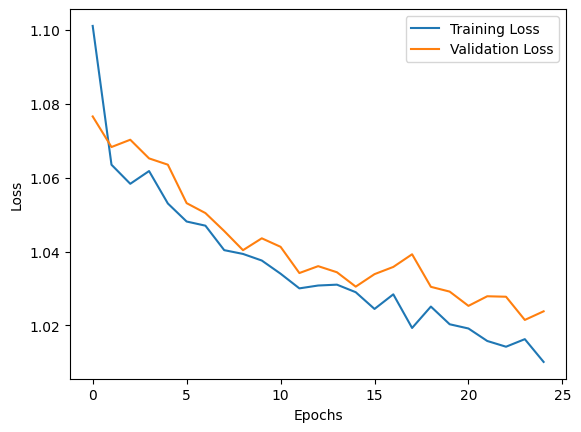

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predicciones

Obtener la exactitud del modelo

In [23]:
y_pred = model.predict(X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1])))
y_pred_labels = y_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Exactitud del modelo:", accuracy)

20/20 [==============================] - 0s 1ms/step
Exactitud del modelo: 0.4937106918238994


Comparaciones de las predicciones y valores reales

In [24]:
# Imprimir solo los primeros 10 elementos de las predicciones y los valores reales
print("Predicciones (primeros 10 elementos)  :", y_pred_labels[:10])
print("Valores reales (primeros 10 elementos):", y_test[:10].values)


Predicciones (primeros 10 elementos)  : [0 2 2 2 2 2 2 2 0 2]
Valores reales (primeros 10 elementos): [2 2 2 2 2 1 2 2 1 0]


In [25]:
combined = pd.DataFrame({'Real': y_test, 'Prediccion': y_pred.argmax(axis=1)})
pd.crosstab(index=combined['Real'], columns=combined['Prediccion'])

Prediccion,0,1,2
Real,,,
0,51,0,131
1,29,2,142
2,18,2,261


In [26]:
combined = combined.merge(data[['HomeTeam', 'AwayTeam']], left_index=True, right_index=True)
combined

,Real,Prediccion,HomeTeam,AwayTeam
1767,2,0,24,17
2421,2,2,2,24
1755,2,2,4,17
163,2,2,11,2
2029,2,2,23,20
...,...,...,...,...
2531,2,2,9,25
1862,1,2,11,19
2061,2,2,30,21
2009,1,2,17,20


In [27]:
model.save('modelos/modelo3.h5')
data.to_csv('modelos/data3.csv', index=False)

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
